In [8]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from scipy.signal import detrend, find_peaks, stft, periodogram
from scipy.fftpack import fft, fftfreq
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from arch import arch_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [11]:
def get_asset_data(ticker: str, start_date: str, end_date: str, api_key: str, plot=False):
    """
    Fetches historical price data for a given asset (e.g., GLD, SLV) between the specified start and end dates.
    
    Args:
        ticker (str): The ticker symbol (e.g., 'GLD', 'SLV').
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.
        api_key (str): Your Polygon.io API key.
        plot (bool): Whether to plot the asset's close prices. Default is False.
        
    Returns:
        pd.DataFrame: DataFrame containing the historical price data for the asset.
    """
    try:
        from polygon import RESTClient
    except ImportError:
        logging.error(
            "The 'polygon' package is required to fetch data. Install it using 'pip install polygon-api-client'.")
        return None

    try:
        logging.info(f"Initializing RESTClient for {ticker}...")
        rest_client = RESTClient(api_key)

        logging.info(
            f"Fetching aggregate bars data for '{ticker}' from {start_date} to {end_date}...")
        # Fetching daily aggregate data
        response = rest_client.get_aggs(
            ticker, 1, 'day', start_date, end_date, limit=50000
        )

        if not response:
            logging.error(
                f"Received empty response from RESTClient for {ticker}.")
            return None

        logging.info(f"Converting response to DataFrame for {ticker}...")
        data = [
            {
                't': item.timestamp,
                'o': item.open,
                'h': item.high,
                'l': item.low,
                'c': item.close,
                'v': item.volume
            }
            for item in response
        ]
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['t'], unit='ms')
        df.set_index('Date', inplace=True)
        df.drop(columns=['t'], inplace=True)

        # Rename columns to match desired format
        df.rename(columns={
            'o': 'Open',
            'h': 'High',
            'l': 'Low',
            'c': 'Close',
            'v': 'Volume'
        }, inplace=True)

        # Convert numeric columns to proper type
        numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        df[numeric_columns] = df[numeric_columns].apply(
            pd.to_numeric, errors='coerce')

        # Optionally plot the data
        if plot:
            plt.figure(figsize=(14, 7))
            plt.plot(df.index, df['Close'],
                     label=f'{ticker} Close Price', color='blue')
            plt.title(f'{ticker} Close Prices ({start_date} to {end_date})')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Save DataFrame to CSV
        csv_filename = f'./data/{ticker}-Prices.csv'
        df.to_csv(csv_filename, index=True)
        logging.info(f"{ticker} prices saved to '{csv_filename}'.")

    except Exception as e:
        logging.error(f"An error occurred in get_asset_data: {e}")
        return None

    return df

2025-03-30 11:53:28,881 - INFO - Initializing RESTClient for GLD...
2025-03-30 11:53:28,883 - INFO - Fetching aggregate bars data for 'GLD' from 2000-01-01 to 2025-03-30...



Fetching data for GLD...


2025-03-30 11:53:29,294 - INFO - Converting response to DataFrame for GLD...


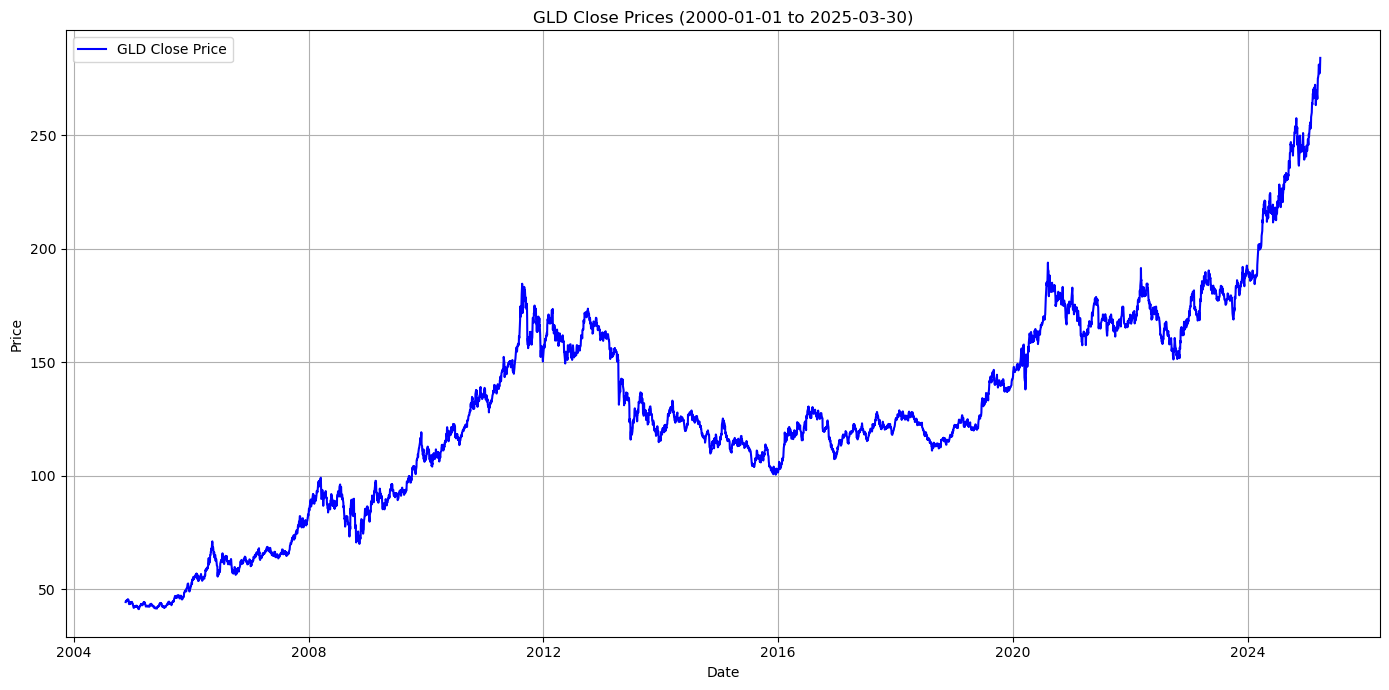

2025-03-30 11:53:29,416 - ERROR - An error occurred in get_asset_data: Cannot save file into a non-existent directory: 'data'
2025-03-30 11:53:29,418 - ERROR - Data retrieval failed for GLD.
2025-03-30 11:53:29,418 - INFO - Initializing RESTClient for SLV...
2025-03-30 11:53:29,418 - INFO - Fetching aggregate bars data for 'SLV' from 2000-01-01 to 2025-03-30...



Fetching data for SLV...


2025-03-30 11:53:29,862 - INFO - Converting response to DataFrame for SLV...


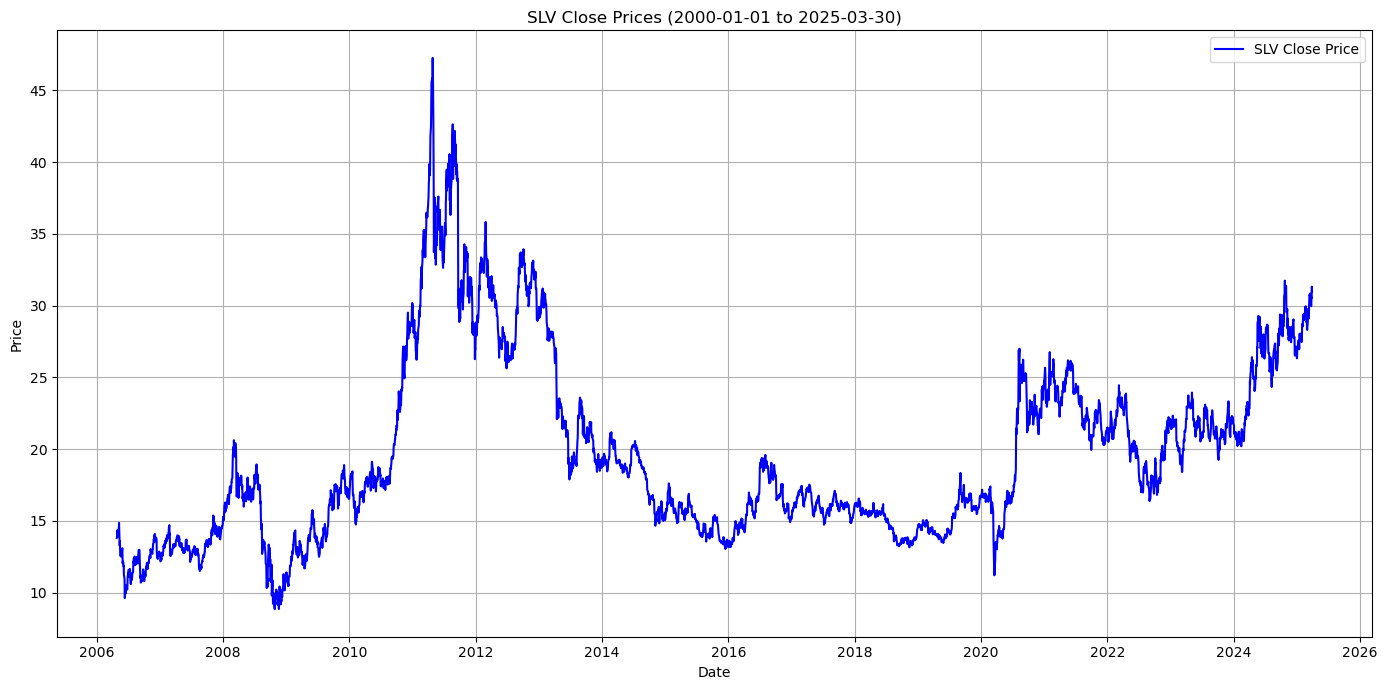

2025-03-30 11:53:29,991 - ERROR - An error occurred in get_asset_data: Cannot save file into a non-existent directory: 'data'
2025-03-30 11:53:29,993 - ERROR - Data retrieval failed for SLV.


In [12]:
# Replace 'YOUR_POLYGON_API_KEY' with your actual Polygon.io API key
API_KEY = 'uwQtl3txGt5BLbecq7ZbIu0ZbuitCGjc'

# Define the date range
start_date = '2000-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# List of tickers
tickers = ['GLD', 'SLV']

# Dictionary to hold data for each ticker
asset_data = {}

# Fetch and plot data for each ticker
for ticker in tickers:
    print(f"\nFetching data for {ticker}...")
    data = get_asset_data(ticker, start_date, end_date, API_KEY, plot=True)
    if data is not None:
        asset_data[ticker] = data
    else:
        logging.error(f"Data retrieval failed for {ticker}.")

In [13]:
commodities = ["GLD", "SLV"]

asset_data = {}

for commodity in commodities:
    dataset = f"../data/{commodity}-Prices.csv"
    #print(f"\n--- Processing dataset: {commodity_name} ---")
    if not os.path.exists(dataset):
        print(f"Error: Dataset file not found: {dataset}")
        continue

    df = pd.read_csv(dataset, parse_dates=["Date"])
    df.sort_values("Date", inplace=True)
    df.set_index("Date", inplace=True)
    asset_data[commodity] = df

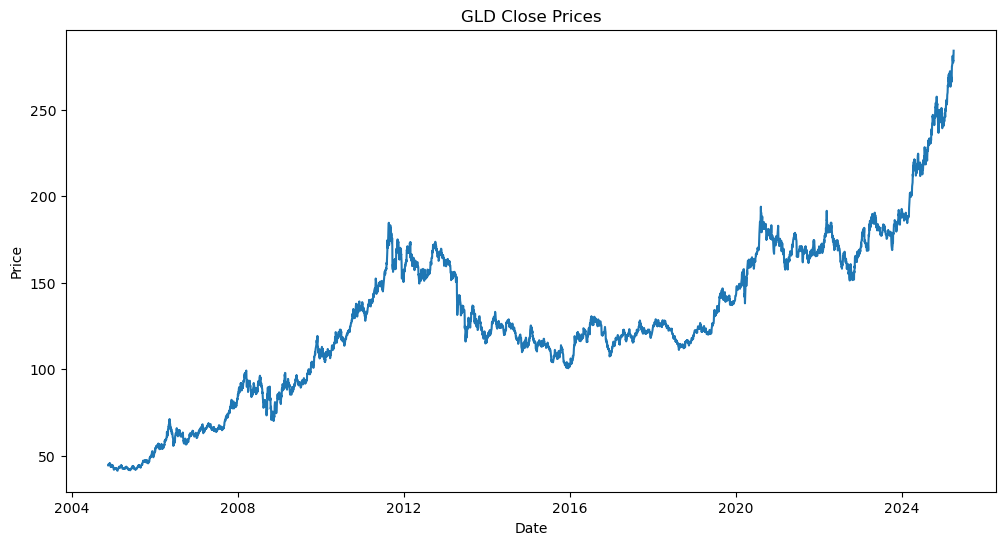

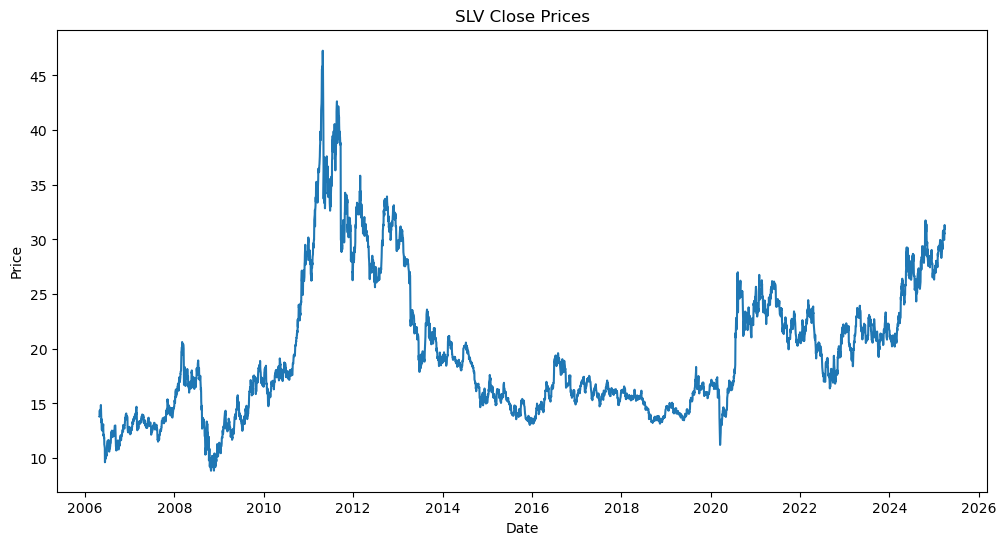

In [14]:
for ticker in commodities:
    plt.figure(figsize=(12, 6))
    plt.plot(asset_data[ticker]["Close"])
    plt.title(f"{ticker} Close Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

In [15]:
def advanced_detrend(df, column="Close", lamb=14400):
    """
    Uses the Hodrick-Prescott filter to extract the trend.
    """
    cycle, trend = hpfilter(df[column], lamb=lamb)
    df["Trend"] = trend
    df["Cycle"] = cycle
    return df, trend

def perform_stationarity_tests(series, signif=0.05, verbose=False):
    """
    Performs both ADF and KPSS tests on the given series.
    """
    results = {}

    # Augmented Dickey-Fuller Test
    try:
        adf_test = adfuller(series, autolag='AIC')
        adf_stat = adf_test[0]
        adf_pvalue = adf_test[1]
        results['ADF'] = {'Test Statistic': adf_stat, 'p-value': adf_pvalue}
        if verbose:
            print('ADF Test:')
            print(f"Test Statistic: {adf_stat}, p-value: {adf_pvalue}")
    except Exception as e:
        print(f"ADF test failed: {e}")
        results['ADF'] = None

    # KPSS Test
    try:
        kpss_test = kpss(series, regression='c', nlags='auto')
        kpss_stat = kpss_test[0]
        kpss_pvalue = kpss_test[1]
        results['KPSS'] = {'Test Statistic': kpss_stat, 'p-value': kpss_pvalue}
        if verbose:
            print('KPSS Test:')
            print(f"Test Statistic: {kpss_stat}, p-value: {kpss_pvalue}")
    except Exception as e:
        print(f"KPSS test failed: {e}")
        results['KPSS'] = None

    return results

def determine_optimal_differencing(series, max_d=2, signif=0.05, verbose=False):
    """
    Determines the optimal differencing order 'd' for the series.
    """
    for d in range(max_d + 1):
        if d == 0:
            differenced_series = series.copy()
        else:
            differenced_series = series.diff(d).dropna()
        test_results = perform_stationarity_tests(
            differenced_series, signif=signif, verbose=verbose)
        adf_pvalue = test_results['ADF']['p-value'] if test_results['ADF'] else None
        kpss_pvalue = test_results['KPSS']['p-value'] if test_results['KPSS'] else None

        adf_stationary = adf_pvalue is not None and adf_pvalue < signif
        kpss_stationary = kpss_pvalue is not None and kpss_pvalue >= signif

        if verbose:
            print(
                f"Differencing order d={d}: ADF stationary={adf_stationary}, KPSS stationary={kpss_stationary}")

        if adf_stationary and kpss_stationary:
            if verbose:
                print(f"Optimal differencing order determined: d={d}")
            return d

    if verbose:
        print(
            f"No optimal differencing order found up to d={max_d}. Using d={max_d}")
    return max_d

# def check_stationarity(series, significance=0.05):
#     """
#     Performs the Augmented Dickey-Fuller (ADF) test on the series. (Either will use Arma or arima based off stationarity)
#     Prints the test statistic and p-value.
#     """
#     series = series.dropna()
#     result = adfuller(series)
#     print("ADF Statistic: {:.4f}".format(result[0]))
#     print("p-value: {:.4f}".format(result[1]))
#     if result[1] < significance:
#         print("The series is stationary.")
#         return True
#     else:
#         print("The series is non-stationary.")
#         return False

def plot_hp_filter_results(df, dataset_name, column="Close", lamb=14400): 
    """
    Function used to plot the different hp filter trends, cycles and original data
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[column], label="Original Close Price", linewidth=1)
    plt.plot(df.index, df["Trend"], label=f"HP Trend (lambda={lamb})", linewidth=2, color='red')
    plt.plot(df.index, df["Cycle"], label=f"HP Cycle (lambda={lamb})", linewidth=1, linestyle='--', color='green')
    plt.title(f"Hodrick-Prescott Filter Decomposition for {dataset_name} (Lambda = {lamb})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


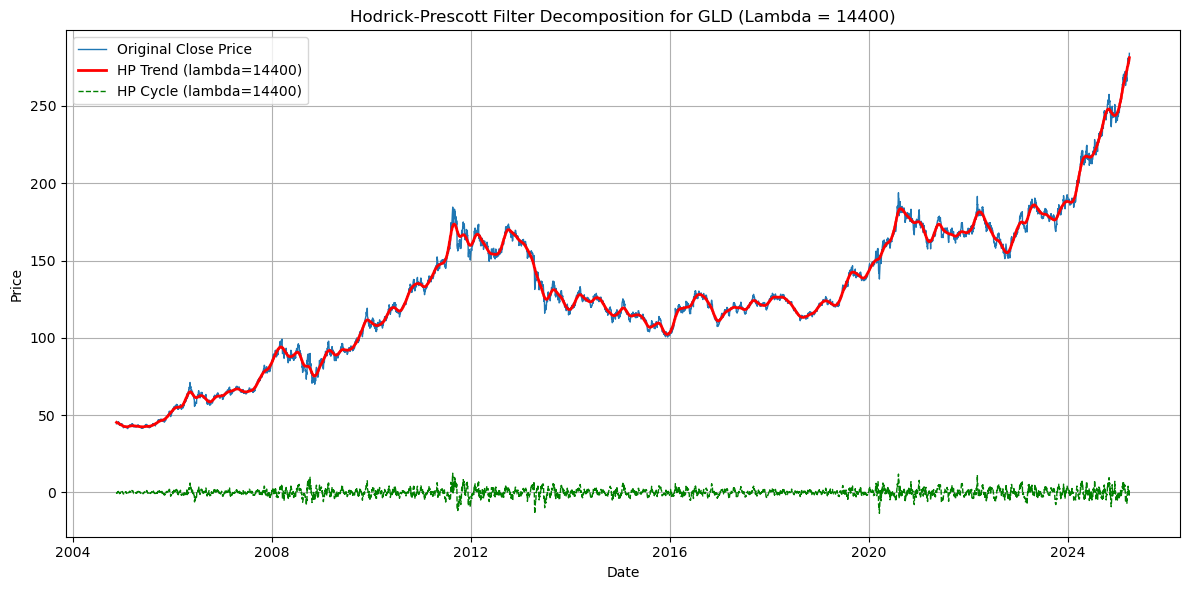

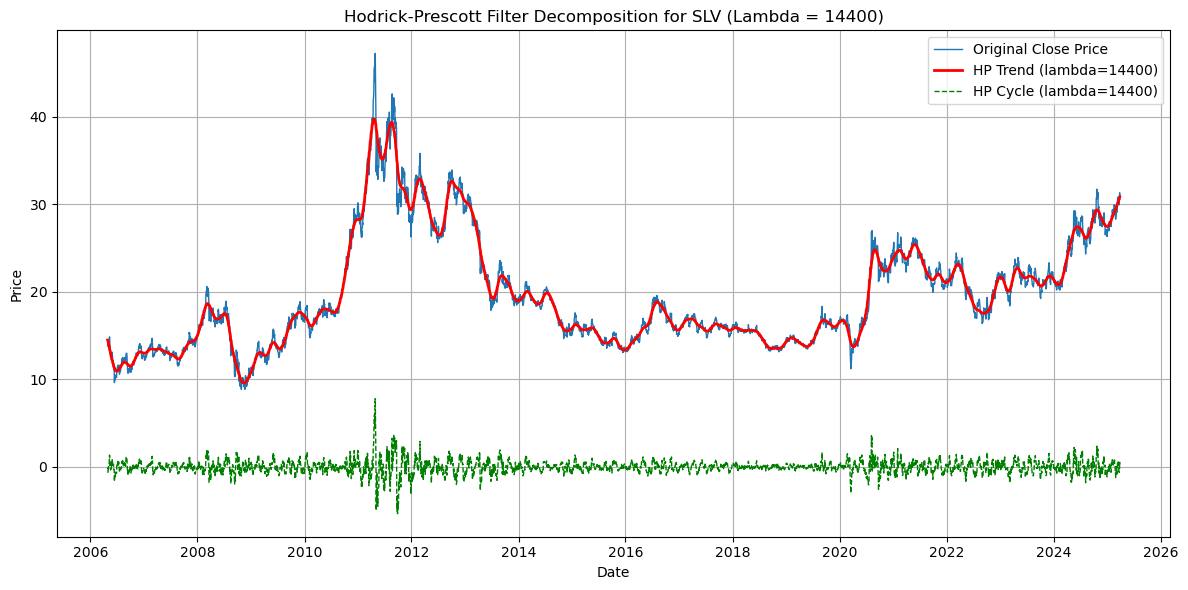

In [16]:
detrended_data = asset_data.copy()

for ticker in commodities:
    detrended_data[ticker], _ = advanced_detrend(detrended_data[ticker], lamb=14400)
    plot_hp_filter_results(detrended_data[ticker], ticker, lamb=14400)


In [17]:
d_values = {}

# Testing the stationarity of the detrended (cyclical) data for each commodity
for ticker in commodities:
    print(f"\n{ticker} Stationarity Testing:")
    close_series = asset_data[ticker]["Close"]
    d = determine_optimal_differencing(close_series, verbose=True)
    d_values[ticker] = d


GLD Stationarity Testing:
ADF Test:
Test Statistic: 0.7264425407574863, p-value: 0.9903510687987105
KPSS Test:
Test Statistic: 7.751478721143409, p-value: 0.01
Differencing order d=0: ADF stationary=False, KPSS stationary=False


/var/folders/rr/1y9v08l11zl1ys_nknn3x7r40000gn/T/ipykernel_60390/1197697344.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')
/var/folders/rr/1y9v08l11zl1ys_nknn3x7r40000gn/T/ipykernel_60390/1197697344.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')


ADF Test:
Test Statistic: -72.03447017346654, p-value: 0.0
KPSS Test:
Test Statistic: 0.2920988201915794, p-value: 0.1
Differencing order d=1: ADF stationary=True, KPSS stationary=True
Optimal differencing order determined: d=1

SLV Stationarity Testing:
ADF Test:
Test Statistic: -1.9817036065206188, p-value: 0.2946525978329057
KPSS Test:
Test Statistic: 0.9968996880188106, p-value: 0.01
Differencing order d=0: ADF stationary=False, KPSS stationary=False
ADF Test:
Test Statistic: -13.707518586944724, p-value: 1.2556224216109528e-25
KPSS Test:
Test Statistic: 0.0666490437686087, p-value: 0.1
Differencing order d=1: ADF stationary=True, KPSS stationary=True
Optimal differencing order determined: d=1


/var/folders/rr/1y9v08l11zl1ys_nknn3x7r40000gn/T/ipykernel_60390/1197697344.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')
/var/folders/rr/1y9v08l11zl1ys_nknn3x7r40000gn/T/ipykernel_60390/1197697344.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')


In [18]:
def fourier_analysis(df, dataset, column="Cycle"):
    """
    Uses Fourier transform to identify dominant frequencies (seasonality) in the data.
    """
    N = len(df)
    T = 1
    y = df[column].values
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    amplitudes = 2.0 / N * np.abs(yf[:N//2])
    peaks, _ = find_peaks(amplitudes, height=0.01 * max(amplitudes))
    print("Detected peaks:", peaks[:5])
    sorted_indices = np.argsort(amplitudes[peaks])[::-1]  # sort descending
    strongest_peaks = peaks[sorted_indices][:5]

    dominant_periods = 1 / xf[strongest_peaks]
    dominant_amplitudes = amplitudes[strongest_peaks]
    print("Strongest detected seasonal periods (in days) and their amplitudes:")
    for period, amplitude in zip(dominant_periods, dominant_amplitudes):
        print(f"Period: {period:.2f} days, Amplitude: {amplitude:.5f}")

    plt.figure(figsize=(10, 5))
    plt.plot(xf, amplitudes)
    plt.xlabel("Frequency (1/day)")
    plt.ylabel("Amplitude")
    plt.title(f"Fourier Transform - Seasonality Detection ({dataset})")
    plt.grid()
    plt.show()

    return dominant_periods

Detected peaks: [16 18 21 23 25]
Strongest detected seasonal periods (in days) and their amplitudes:
Period: 56.29 days, Amplitude: 0.48766
Period: 29.61 days, Amplitude: 0.44315
Period: 38.22 days, Amplitude: 0.41943
Period: 66.52 days, Amplitude: 0.40424
Period: 37.12 days, Amplitude: 0.40346


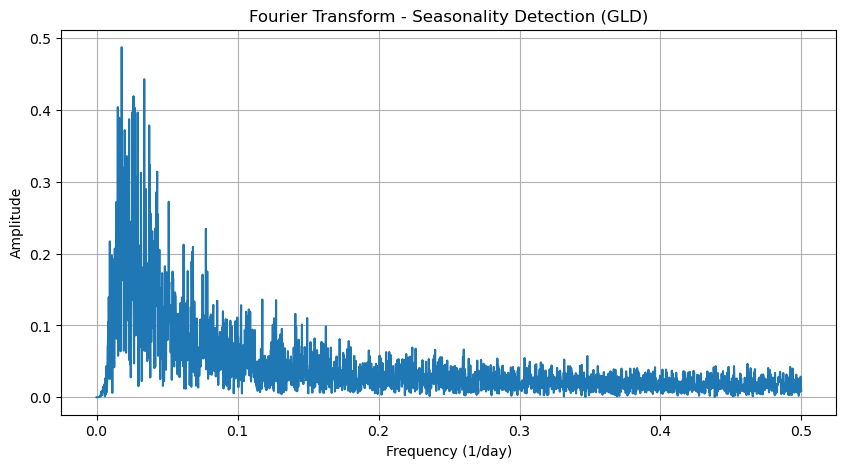

Detected peaks: [14 16 20 25 27]
Strongest detected seasonal periods (in days) and their amplitudes:
Period: 34.24 days, Amplitude: 0.15385
Period: 35.52 days, Amplitude: 0.13545
Period: 29.57 days, Amplitude: 0.12684
Period: 50.11 days, Amplitude: 0.12141
Period: 31.73 days, Amplitude: 0.12051


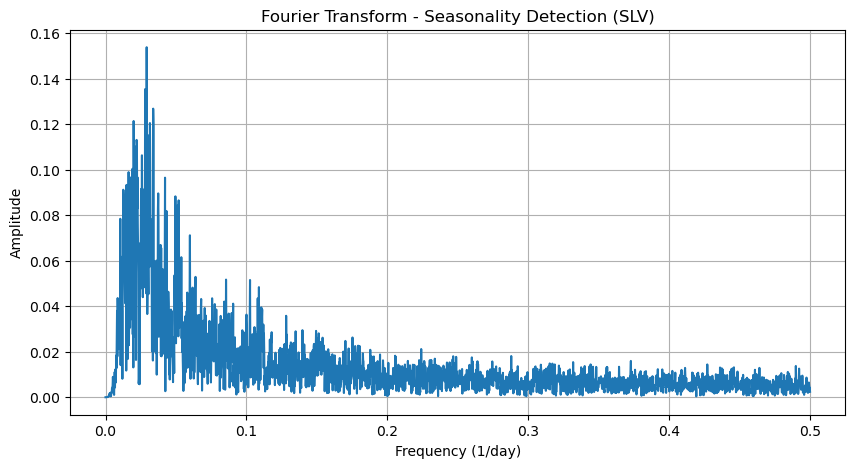

In [19]:
top_fourier_values = {}

for ticker in commodities:
    dominant_periods = fourier_analysis(detrended_data[ticker], ticker, column="Cycle")
    top_fourier_values[ticker] = dominant_periods    


GLD Seasonal Decomposition:
Performing seasonal decomposition with period=56 and model='additive'...
Seasonal decomposition completed.


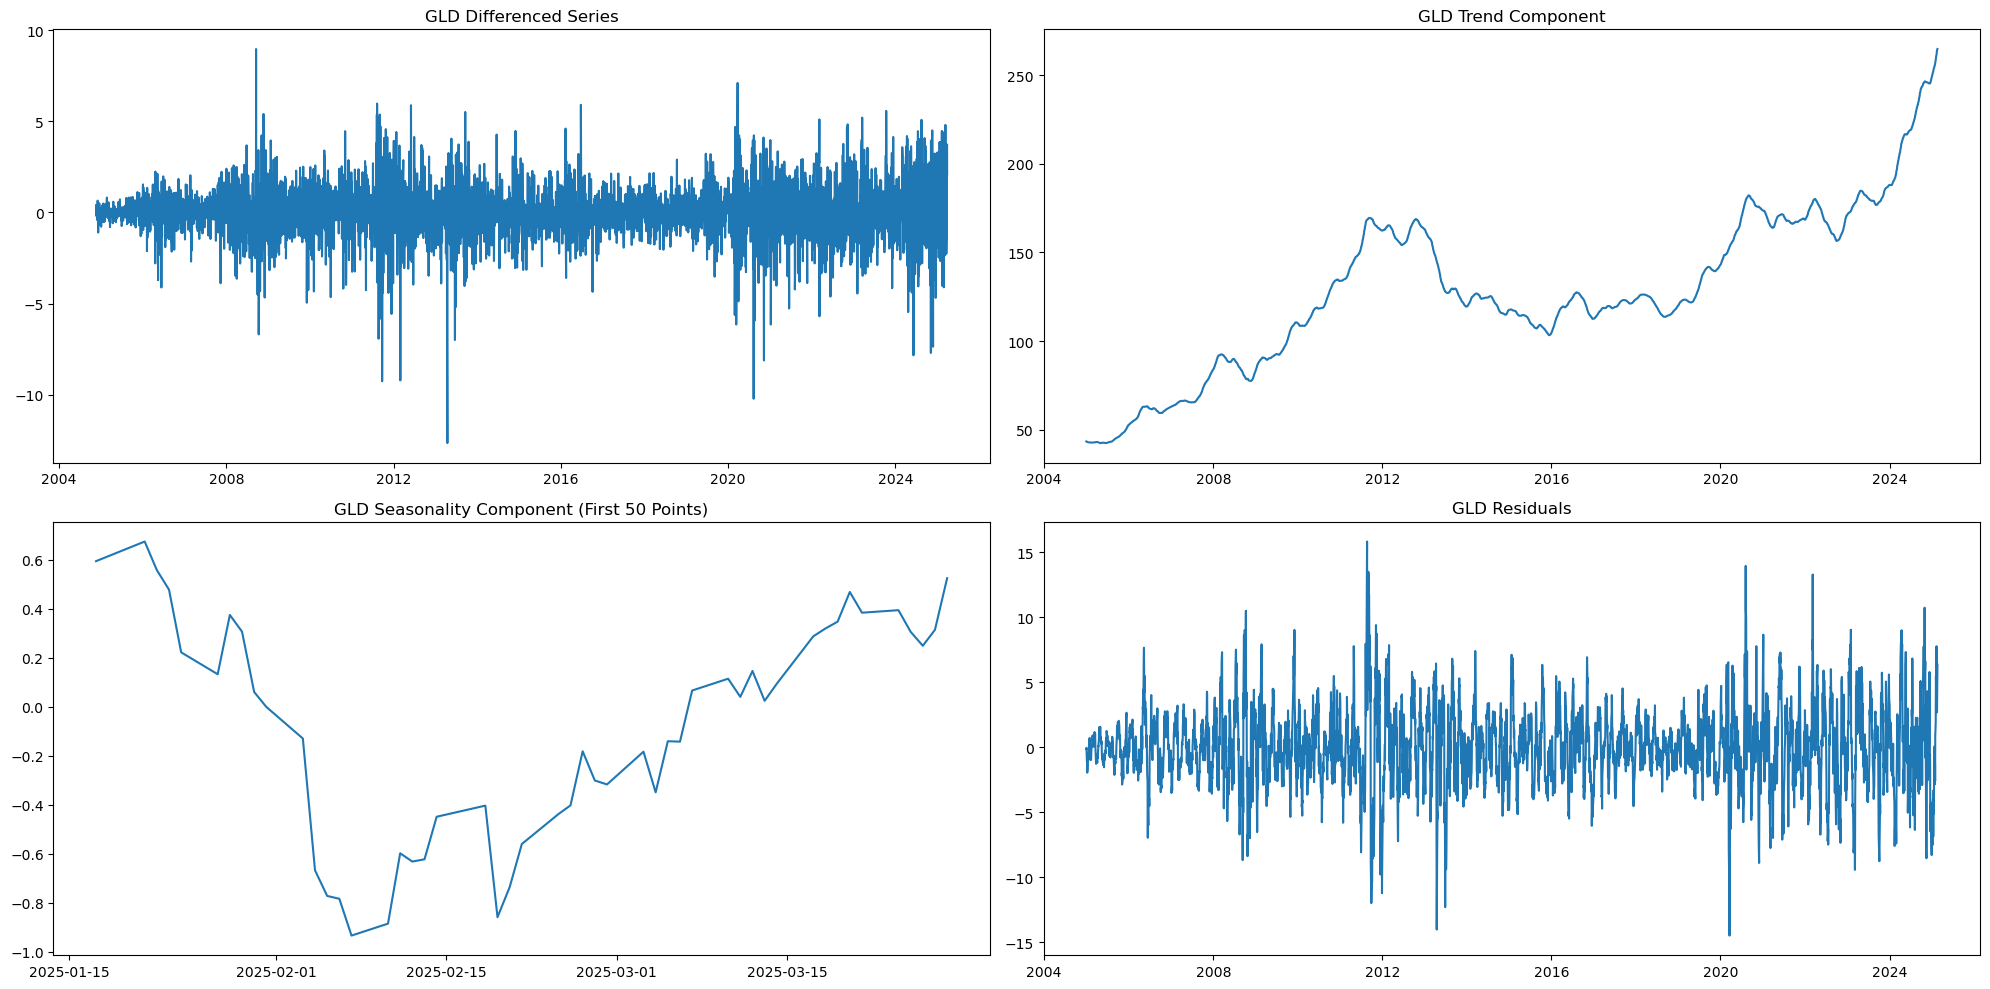


SLV Seasonal Decomposition:
Performing seasonal decomposition with period=34 and model='additive'...
Seasonal decomposition completed.


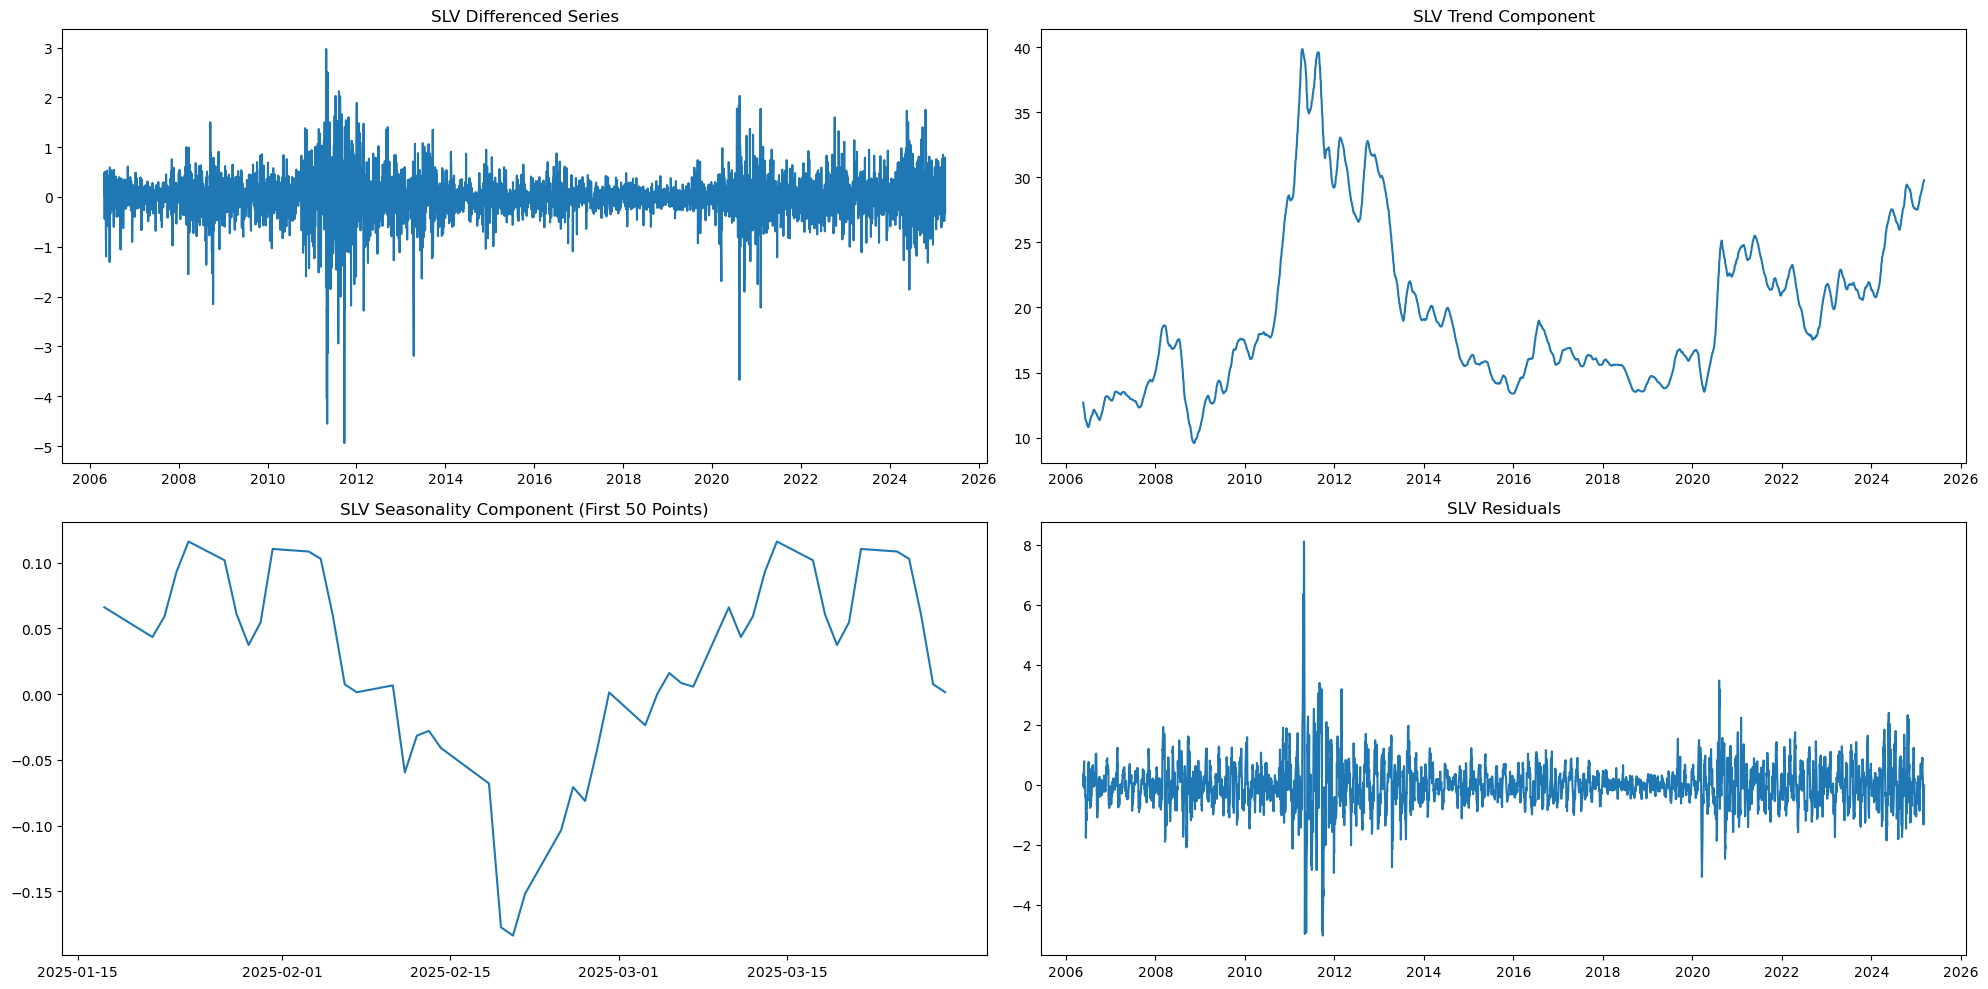

In [20]:
def seasonal_decomposition_analysis(series, seasonal_period, model='additive'):
    """
    Performs seasonal decomposition on a time series.
    """
    try:
        print(
            f"Performing seasonal decomposition with period={seasonal_period} and model='{model}'...")
        decomposition = seasonal_decompose(
            series, model=model, period=seasonal_period)
        print("Seasonal decomposition completed.")
        return decomposition
    except Exception as e:
        print(f"An error occurred during seasonal decomposition: {e}")
        return None

def plot_seasonal_decomposition(ts, ticker, seasonal_period=7):
    decomposition = seasonal_decomposition_analysis(ts, seasonal_period)

    if decomposition is None:
        print(
            f"Seasonal decomposition plot skipped for {ticker}: No valid decomposition.")
        return

    trend = decomposition.trend
    seasonality = decomposition.seasonal
    resid = decomposition.resid

    fig = plt.figure(figsize=(20, 10))

    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    ax1.plot(ts.diff().dropna())
    ax1.set_title(f"{ticker} Differenced Series")

    ax2.plot(trend)
    ax2.set_title(f"{ticker} Trend Component")

    ax3.plot(seasonality[:-50:-1])
    ax3.set_title(f"{ticker} Seasonality Component (First 50 Points)")

    ax4.plot(resid)
    ax4.set_title(f"{ticker} Residuals")

    plt.tight_layout()
    plt.show()
    return trend, seasonality, resid

# Using the top period from the fourier analysis to perform seasonal decomposition on original data
for ticker in commodities:
    period = int(top_fourier_values[ticker][0])
    print(f"\n{ticker} Seasonal Decomposition:")
    close_series = asset_data[ticker]['Close']
    trend, seasonality, resid = plot_seasonal_decomposition(close_series, ticker, seasonal_period=period)


Plotting ACF and PACF for GLD...


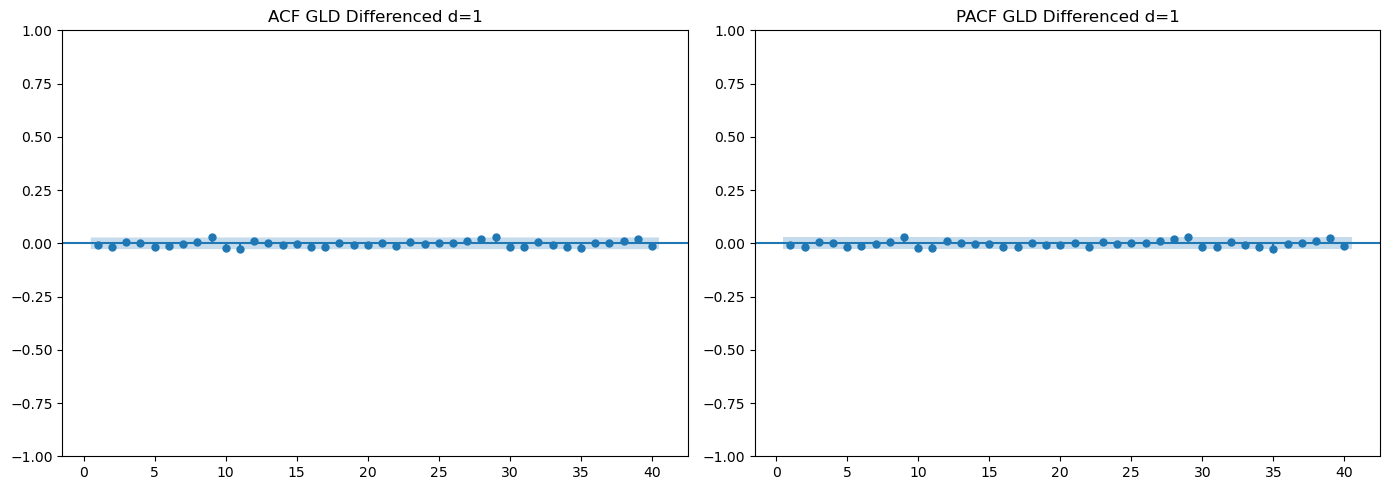


Plotting ACF and PACF for SLV...


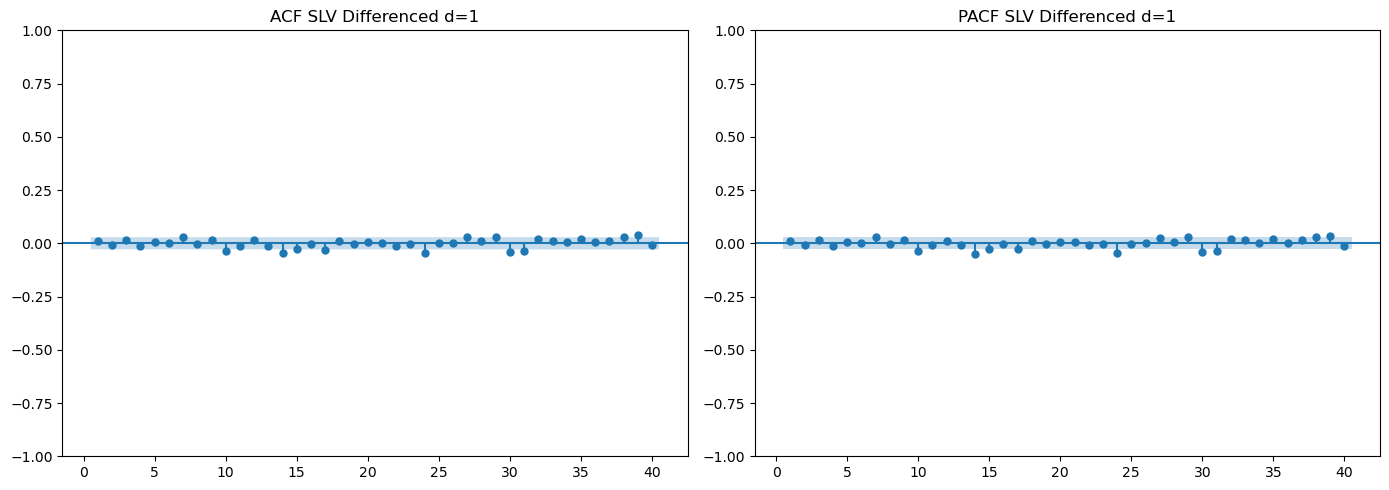

In [21]:
def plot_acf_pacf(series, lags=40, title=''):
    """
    Plots ACF and PACF for the given series.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plot_acf(series, lags=lags, ax=axes[0], zero=False)
    axes[0].set_title(f"ACF {title}")
    plot_pacf(series, lags=lags, ax=axes[1], zero=False)
    axes[1].set_title(f"PACF {title}")
    plt.tight_layout()
    plt.show()

# Plotting the ACF and PACF for the differenced series of each commodity
for ticker in commodities:
    print(f"\nPlotting ACF and PACF for {ticker}...")
    d = d_values[ticker]
    differenced_series = asset_data[ticker]['Close'].diff(d).dropna()
    plot_acf_pacf(differenced_series, title=f"{ticker} Differenced d={d}")

In [22]:
def auto_arima_grid_search_over_seasonal_periods(series, m_values, max_p=3, max_q=3, max_P=2, max_Q=2, max_d=2, max_D=1, verbose=False):
    """
    Performs grid search over different seasonal periods to find the optimal SARIMA parameters.
    """
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None
    best_m = None
    results = []

    for m in m_values:
        if verbose:
            print(f"\nTesting seasonal period m={m}")
        try:
            stepwise_model = pm.auto_arima(series, start_p=0, start_q=0,
                                           max_p=max_p, max_q=max_q,
                                           d=None, max_d=max_d,
                                           start_P=0, start_Q=0,
                                           max_P=max_P, max_Q=max_Q,
                                           D=None, max_D=max_D,
                                           seasonal=True, m=m,
                                           trace=verbose,
                                           error_action='ignore',
                                           suppress_warnings=True,
                                           stepwise=True,
                                           information_criterion='aic')
            aic = stepwise_model.aic()
            results.append({'m': m, 'model': stepwise_model, 'aic': aic})

            if aic < best_aic:
                best_aic = aic
                best_order = stepwise_model.order
                best_seasonal_order = stepwise_model.seasonal_order
                best_m = m
                best_model = stepwise_model
                if verbose:
                    print(f"New best model found for m={m} with AIC={aic}")

        except Exception as e:
            if verbose:
                print(f"Failed to fit SARIMA model for m={m}: {e}")
            continue

    if verbose and best_m is not None:
        print(
            f"\nBest model overall: Seasonal Period m={best_m}, Order={best_order}, Seasonal Order={best_seasonal_order}, AIC={best_aic}")

    return {'best_model': best_model, 'best_m': best_m, 'results': results}

def fit_sarima_garch(train_data, seasonal_period, garch_order=(1, 1), d_order=0):
    """
    Fits a SARIMA model using auto_arima (with a predetermined differencing order)
    and then fits a GARCH model on the residuals.
    """
    # Fit SARIMA (note: d is forced to d_order based on our stationarity tests)
    model = pm.auto_arima(
        train_data,
        seasonal=True,
        m=seasonal_period,
        d=d_order,             
        stepwise=True,
        suppress_warnings=True,
        trace=True,
        start_p=1, start_q=1, max_p=3, max_q=3,
        start_P=0, start_Q=0, max_P=2, max_Q=2,
        n_jobs=-1,
        parallel=True,
        error_action='ignore'
    )
    print(f"Fitted SARIMA order: {model.order}, seasonal order: {model.seasonal_order}")

    # Use residuals from the SARIMA model (limit to a rolling window if needed)
    residuals = model.resid()
    window_length = 300  # adjust as necessary
    if len(residuals) > window_length:
        residuals = residuals[-window_length:]
    
    # Fit GARCH on the SARIMA residuals
    garch = arch_model(residuals, vol='Garch', p=garch_order[0], q=garch_order[1])
    garch_fit = garch.fit(update_freq=5, disp='off')

    return model, garch_fit

def forecast_sarima_garch(model, garch_model, steps):
    """
    Forecasts future values using the fitted SARIMA and GARCH models.
    """
    # Forecast with the SARIMA model
    sarima_forecast = model.predict(n_periods=steps)
    
    # Forecast volatility using the GARCH model
    garch_forecast = garch_model.forecast(horizon=steps)
    volatility = np.sqrt(garch_forecast.variance.iloc[-1])
    
    return sarima_forecast, volatility

def evaluate_forecast(test_data, forecast):
    """
    Evaluates forecast accuracy using multiple metrics.
    """
    # Calculate error metrics
    mae = np.mean(np.abs(test_data - forecast))
    mse = np.mean((test_data - forecast)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
    }

def analyze_commodity(commodity_name, seasonal_grid_search=False):
    """
    Loads commodity data, applies detrending and stationarity check, performs Fourier analysis,
    fits a SARIMA-GARCH model, and forecasts future prices.
    """
    print(f"\n--- Analyzing {commodity_name} ---")
    dataset_path = f"../data/{commodity_name}-Prices.csv"
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset file not found: {dataset_path}")
        return
    
    # Loading in the commodity dataset
    df = pd.read_csv(dataset_path, parse_dates=["Date"])
    #df = df[df["Date"] >= pd.to_datetime("2020-01-01")]  # filter recent data
    df.sort_values("Date", inplace=True)
    df.set_index("Date", inplace=True)

    # Utilizes the HP Filter to extract trend and cycle
    df_processed, trend = advanced_detrend(df.copy())
    
    # Model on the original series data (for forecasting with Arima)
    train_size = int(len(df_processed) * 0.8)
    series_to_model = df_processed["Close"]
    train = series_to_model[:train_size]
    test = series_to_model[train_size:]
    
    # Determine seasonal period from Fourier analysis on the cycle component after HP filter
    dominant_periods = fourier_analysis(df_processed, commodity_name, column="Cycle")
    print(f"Dominant seasonal period from Fourier analysis: {round(dominant_periods[0])} days")
    
    # Optional: refine seasonal period using grid search with top 3 peaks from fourier analysis
    if seasonal_grid_search:
        m_values = [round(dominant_periods[0]), round(dominant_periods[1]), round(dominant_periods[2])]
        grid_search_results = auto_arima_grid_search_over_seasonal_periods(train, m_values, verbose=True)
        if grid_search_results['best_m'] is not None:
            dominant_period = grid_search_results['best_m']
            print(f"Refined seasonal period from grid search: {dominant_period} days\n")
    else:
        dominant_period = round(dominant_periods[0]) # use top period from Fourier analysis
    
    # Fit SARIMA-GARCH model using determined dominant seasonal period and differencing order
    d = d_values[commodity_name]
    sarima_model, garch_model = fit_sarima_garch(train, seasonal_period=dominant_period, garch_order=(1, 1), d_order=d)
    print("Finished fitting SARIMA-GARCH models.\n")
    
    forecast_steps = len(test)
    print(f"Forecasting {forecast_steps} steps ahead for {commodity_name}...\n")
    # Forecast future values
    mean_forecast, volatility = forecast_sarima_garch(sarima_model, garch_model, steps=forecast_steps)

    mean_forecast_np = np.array(mean_forecast)
    volatility_np = np.array(volatility)
    print("Length of mean_forecast", len(mean_forecast))
    print("Length of volatility", len(volatility))
    print("Length of test", len(test))
    predictions = pd.DataFrame({
        'Mean': mean_forecast_np,
        'Lower': mean_forecast_np - 1.96 * volatility_np,
        'Upper': mean_forecast_np + 1.96 * volatility_np
    }, index=test.index)
    
    eval_metrics = evaluate_forecast(test, mean_forecast_np)
    print("Forecast Evaluation Metrics:")
    for metric, value in eval_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plot forecasts against actual data
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Values')
    plt.plot(predictions.index, predictions['Mean'], label='SARIMA-GARCH Forecast', color='green')
    plt.fill_between(predictions.index, predictions['Lower'], predictions['Upper'], color='gray', alpha=0.2)
    plt.title(f'{commodity_name} Price Forecast with Volatility Bands')
    plt.legend()
    plt.show()
    
    # Plot GARCH diagnostics
    garch_model.plot(annualize='D')
    plt.suptitle(f'GARCH Model Diagnostics - {commodity_name}')
    plt.show()
    return sarima_model, garch_model, predictions

In [23]:
# Performs analysis rolling wise on the commodities
# with predictions every 100 days
def analyze_commodity_rolling(commodity_name, forecast_horizon=5, interval=100):
    """
    Performs rolling ARIMA-GARCH predictions for the given commodity.

    Args:
        commodity_name (str): The name of the commodity to analyze.
        window_size (int): The size of the rolling window for training the model.
        forecast_horizon (int): The number of days to forecast at each step.

    Returns:
        pd.DataFrame: A DataFrame containing the forecasts and actual values.
    """
    print(f"\n--- Analyzing {commodity_name} (Rolling) ---")
    dataset_path = f"data/{commodity_name}-Prices.csv"
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset file not found: {dataset_path}")
        return None

    df = pd.read_csv(dataset_path, parse_dates=["Date"])
    df = df[df["Date"] >= pd.to_datetime("2022-01-01")]
    df.sort_values("Date", inplace=True)
    df.set_index("Date", inplace=True)

    df_processed, trend = advanced_detrend(df.copy())
    series_to_model = df_processed["Close"]

    dominant_periods, _ = fourier_analysis(df_processed, commodity_name, column="Cycle")
    dominant_period = round(dominant_periods[0])
    
    results = []

    for i in range(interval, len(series_to_model) - forecast_horizon + 1, interval):
        train = series_to_model[:i] # want to take into account everything before
        test = series_to_model[i:i + forecast_horizon]

        d = d_values[commodity_name]  # Use your pre-determined differencing order
        try:
            sarima_model, garch_model = fit_sarima_garch(train, seasonal_period=dominant_period, garch_order=(1, 1), d_order=d)
            mean_forecast, volatility = forecast_sarima_garch(sarima_model, garch_model, steps=forecast_horizon)

            for j, forecast_value in enumerate(mean_forecast):
                results.append({
                    'Date': test.index[j],
                    'Forecast': forecast_value,
                    'Actual': test.values[j],
                    'Volatility': volatility[j] if len(volatility) > j else np.nan,
                })

        except Exception as e:
            print(f"Error during forecasting at index {i}: {e}")

    results_df = pd.DataFrame(results)

    # Plotting the results
    plt.figure(figsize=(14, 7))
    plt.plot(series_to_model.index, series_to_model, label='Actual Values', alpha=0.7)
    plt.plot(results_df['Date'], results_df['Forecast'], label='Rolling Forecast', color='red')
    plt.fill_between(results_df['Date'], results_df['Forecast'] - 1.96 * results_df['Volatility'],
                     results_df['Forecast'] + 1.96 * results_df['Volatility'],
                     color='gray', alpha=0.2, label='Volatility Bands')
    plt.title(f'{commodity_name} Rolling ARIMA-GARCH Forecast')
    plt.legend()
    plt.savefig(f"results/{commodity_name}-arima-forecast-rolling.png")
    plt.show()

    # Calculate evaluation metrics
    eval_metrics = evaluate_forecast(results_df['Actual'], results_df['Forecast'])
    print("Forecast Evaluation Metrics:")
    for metric, value in eval_metrics.items():
        print(f"{metric}: {value:.4f}")

    return results_df


--- Analyzing GLD ---
Detected peaks: [16 18 21 23 25]
Strongest detected seasonal periods (in days) and their amplitudes:
Period: 56.29 days, Amplitude: 0.48766
Period: 29.61 days, Amplitude: 0.44315
Period: 38.22 days, Amplitude: 0.41943
Period: 66.52 days, Amplitude: 0.40424
Period: 37.12 days, Amplitude: 0.40346


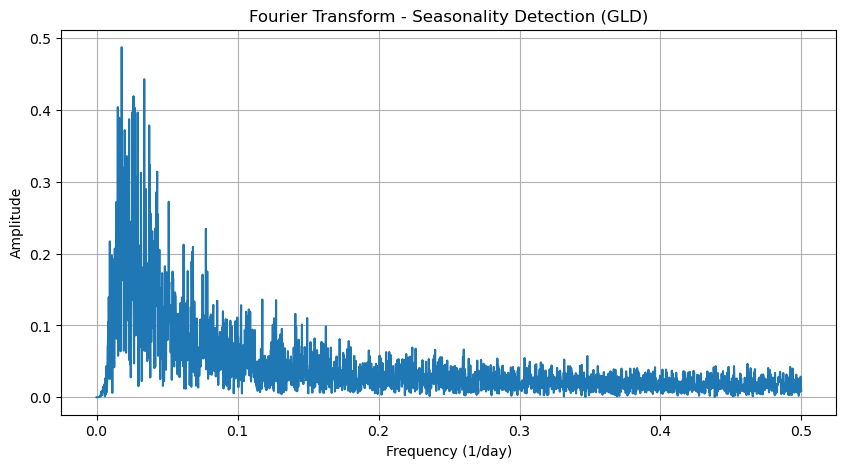

Dominant seasonal period from Fourier analysis: 56 days
Performing stepwise search to minimize aic


/opt/anaconda3/envs/commodities/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,1,1)(0,0,0)[56] intercept   : AIC=13913.714, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[56] intercept   : AIC=13909.723, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[56] intercept   : AIC=13913.679, Time=7.41 sec


KeyboardInterrupt: 

In [24]:
saved_results = {}
for ticker in commodities:
    results = analyze_commodity(ticker, seasonal_grid_search=False)
    saved_results[ticker] = results